In [505]:
import ROOT
from ROOT import TCanvas, TPad, TFile, TPaveLabel, TPaveText, TH1F, TH2F
from ROOT import gROOT, gBenchmark, gRandom, gSystem, RDataFrame
from scipy.optimize import differential_evolution

import pandas as pd
import random
import numpy as np

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

from scipy import stats
from scipy.stats import crystalball

from scipy.optimize import curve_fit

## Loading Data
For each pysics event in the file we get:
- particle momentum in x direction
- particle momentum in y direction
- particle momentum in z direction
- particle x
- particle y
- particle z
- theta
- phi
- cluster energy

Then we separate these into an array of inputs (everything except for the cluster energy) and our desired output (cluster energy)

In [2]:
File = "PDG22_P5000_T0_phi0.root"
inFile = ROOT.TFile(File ,"READ")
tree = inFile.Get("t;1")
data = [
    [
        evt.cl_E_ecal,
        evt.part_p, 
        evt.part_x, 
        evt.part_y,
        evt.part_z,
        evt.part_theta,
        evt.part_phi
    ] for evt in tree
]
data = np.array(data)
data = np.transpose(data)
y = data[0]
X = np.delete(data, 0, axis = 0)
X = np.transpose(X)

In [5]:
del data
del inFile
del tree

Next we downsample to 10,000,000 physics events to use for training

In [6]:
sel_ind = np.random.choice(50077252, 10000000)
X_sel = X[sel_ind]
y_sel = y[sel_ind]

In [7]:
regr = RandomForestRegressor(max_depth=32, random_state=0, n_jobs=4, verbose = 1)
regr.fit(X_sel, y_sel)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 17.2min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 40.0min finished


RandomForestRegressor(max_depth=32, n_jobs=4, random_state=0, verbose=1)

Again we select a new sample of 10,000,000 events to test the model on

In [13]:
sel_ind = np.random.choice(50077252, 1000000)
X_sel = X[sel_ind]
y_sel = y[sel_ind]

Now we train a Random Forest Regressor model with the max tree depth parameter set to 32

Using the input vector (x,y,p,theta,phi) we predict the cluster cluster energy using our regressor

In [14]:
obs = y_sel
pred = regr.predict(X_sel)
errors = [abs(pred[i] - obs[i]) for i in range(len(obs))]

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    8.3s finished


Here we can see how the model performs (blue) compared to the results from the full sim (orange). The difference in distribution comes from the fact that our model cannot learn the entropy caused by the crystal ball distribution of the cluster energy we see in the full sim. Instead it will just predict the mean of that distribution (hence the tighter distribution around 700 MeV in the blue histogram)

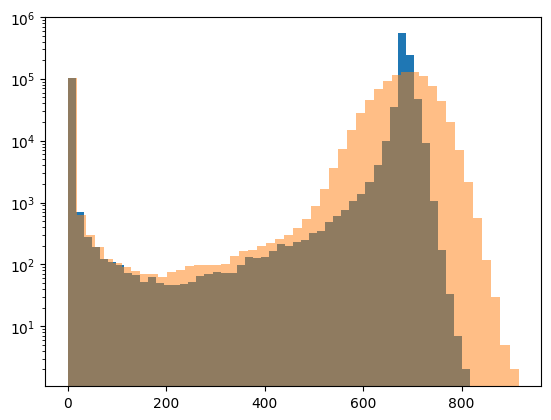

In [15]:
pred_counts, pred_bins = np.histogram(pred, bins=50)
obs_counts, obs_bins = np.histogram(obs, bins=50)
plt.hist(pred_bins[:-1], pred_bins, weights=pred_counts, alpha=1)
plt.hist(obs_bins[:-1], obs_bins, weights=obs_counts, alpha=0.5)
plt.yscale('log')

Here we can see the distribution of cluster energy corresponding to different (x,y) particles inputs as taken directly from the full sim.

In [ ]:
plt.figure(figsize=(16,12))
plt.scatter(np.transpose(X_sel)[1], np.transpose(X_sel)[2], c=(obs-min(obs))/(max(obs)-min(obs)), s=10, alpha=0.1)
plt.xlim(0,4500)
plt.ylim(0,3500)
plt.show()

Here we see what our model predicts for the cluster energy per (x,y) coordinate pair. The irregularities in the calorimiter are easy to see here, but the cluster energy is far less noisy since we are missing the entropy induced by the random nature of the particle showers. 

In [ ]:
plt.figure(figsize=(16,12))
plt.scatter(np.transpose(X_sel)[1], np.transpose(X_sel)[2], c=(pred-min(pred))/(max(pred)-min(pred)), s=10, alpha=0.1)
plt.xlim(0,4500)
plt.ylim(0,3500)
plt.show()

Now we investigate the crystal ball distribution of the cluster energy in a more or less uniform section of the calorimeter. To do this we select a kernel in the green section of the calorimeter and learn the local probability distribution from the observed data in the full sim.

In [ ]:
x_0,y_0,r = 2000,2000,500

In [ ]:
x_kern = np.transpose(X_sel[(X_sel.transpose()[3]-x_0)**2 + (X_sel.transpose()[4]-y_0)**2 < r**2])[3]
y_kern = np.transpose(X_sel[(X_sel.transpose()[3]-x_0)**2 + (X_sel.transpose()[4]-y_0)**2 < r**2])[4]
pred_kern = pred[(X_sel.transpose()[3]-x_0)**2 + (X_sel.transpose()[4]-y_0)**2 < r**2]
obs_kern = obs[(X_sel.transpose()[3]-x_0)**2 + (X_sel.transpose()[4]-y_0)**2 < r**2]

Here we can see the discrepancy between the outputs from our regressor compared to the outputs from the full sim in a smaller region of the calorimeter.

In [ ]:
plt.figure(figsize=(2,2))
plt.scatter(x_kern, y_kern, c=(obs_kern-min(obs_kern))/(max(obs_kern)-min(obs_kern)), s=10, alpha=0.1)
plt.show()
plt.figure(figsize=(2,2))
plt.scatter(x_kern, y_kern, c=(pred_kern-min(pred_kern))/(max(pred_kern)-min(pred_kern)), s=10, alpha=0.1)
plt.show()

In [ ]:
obs_kern_counts, obs_kern_bins = np.histogram(obs_kern, bins=50)
pred_kern_counts, pred_kern_bins = np.histogram(pred_kern, bins=50)
plt.hist(pred_kern_bins[:-1], pred_kern_bins, weights=pred_kern_counts, alpha=1)
plt.hist(obs_kern_bins[:-1], obs_kern_bins, weights=obs_kern_counts, alpha=0.5)
plt.yscale('log')
plt.show()

First we can learn the mean and standard deviation of the crystal ball distribution using some simple statistics.

In [ ]:
mu

In [16]:
mu = obs_bins[obs_counts.argmax()]
sigma = obs[obs>200].std()
mu, sigma

(np.float64(695.9828491210938), np.float64(52.84967944340788))

Now that we have some basic information about the distribution we can fit the rest of the parameters using the scipy stats fit method. This method can be optimized to give an even better estimation of the distribution, but for now this works.

In [34]:
dist_learned = stats.fit(crystalball, obs[(obs>200)*(obs<900)], [(0,1000), (2,2), (mu-10,mu+10), (sigma-10,sigma+10)], method="mse")
dist_learned.params

FitParams(beta=np.float64(580.3186760102626), m=np.float64(2.0), loc=np.float64(685.9828491210938), scale=np.float64(50.868121306630066))

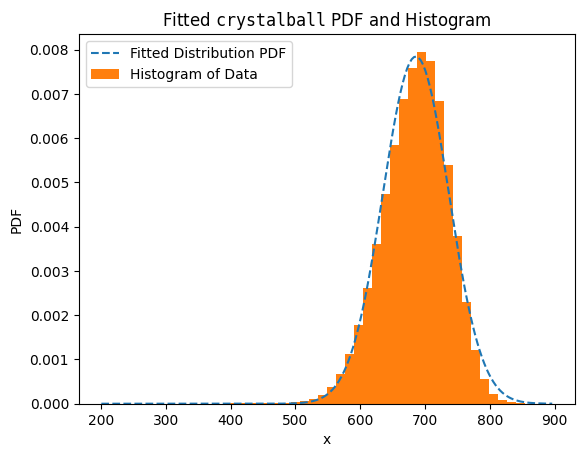

In [36]:
dist_learned.plot()
plt.show()

We can also sample from the learned distribution to verify its quality.

In [ ]:
r = crystalball.rvs(50, 2, 700, 50, size=1000000)
counts, bins = np.histogram(r, bins=50)
plt.hist(bins[:-1], bins, weights=counts, alpha=1)
plt.show()

Now with the crystal ball distriubtion in hand we can add some entropy to our predictions. We do this as follows:
- First we check if the data point is not an outlier (< 3 standard deviation from the mean). Very low and very high values are created by non-uniformities in the calorimeter and do not exhibit the same distribution.
- Next we calculate a scaling parameter alpha which depends on a set constant gamma. For small gamma we add more entropy, for larger gamma we dec the entropy added.
- We sample from the crystal ball distribution and make a linear combination of the sample and the prediciton from our regressor. Smaller gamma means we weight the sample from the crystal ball distribution more, larger gamma means we weight the regressor prediciton more.

In [ ]:
pred_plus_mc = []
beta, m, scale, loc, gamma = dist_learned.params.beta, dist_learned.params.m, dist_learned.params.scale, dist_learned.params.loc, 0.00075
eThresh = loc - 3*sigma

for p in pred:
    if p> eThresh:
        alpha = 1/(gamma*(loc-p)**2+1)
        updated_pred = crystalball.rvs(beta = beta, m = m, scale = scale, loc = p)*alpha + p*(1-alpha)
    else:
        updated_pred = p
    pred_plus_mc.append(updated_pred)

As you can now see the distributions are almost identical after we add in the randomness from our crystal ball distribution. Below we can also see how the new predictions that include the randomness are similar to data taken directly from the fast sim when we plot against (x,y) coordinate pairs.

In [ ]:
pred_counts, pred_bins = np.histogram(pred_plus_mc, bins=100)
obs_counts, obs_bins = np.histogram(obs, bins=100)
plt.hist(pred_bins[:-1], pred_bins, weights=pred_counts, alpha=1)
plt.hist(obs_bins[:-1], obs_bins, weights=obs_counts, alpha=0.5)
plt.yscale('log')
plt.show()

In [ ]:
plt.figure(figsize=(16,12))
plt.scatter(np.transpose(X_sel)[1], np.transpose(X_sel)[2], c=pred_plus_mc, s=10, alpha=0.1)
plt.xlim(0,4500)
plt.ylim(0,3500)
plt.show()

In [ ]:
plt.figure(figsize=(16,12))
plt.scatter(np.transpose(X_sel)[1], np.transpose(X_sel)[2], c=obs, s=10, alpha=0.1)
plt.xlim(0,4500)
plt.ylim(0,3500)
plt.show()

In [ ]:
x_0,y_0,r = 2000,2000,100
x_kern = np.transpose(X_sel[(X_sel.transpose()[3]-x_0)**2 + (X_sel.transpose()[4]-y_0)**2 < r**2])[3]
y_kern = np.transpose(X_sel[(X_sel.transpose()[3]-x_0)**2 + (X_sel.transpose()[4]-y_0)**2 < r**2])[4]
pred_kern = np.array(pred_plus_mc)[(X_sel.transpose()[3]-x_0)**2 + (X_sel.transpose()[4]-y_0)**2 < r**2]
obs_kern = obs[(X_sel.transpose()[3]-x_0)**2 + (X_sel.transpose()[4]-y_0)**2 < r**2]

In [ ]:
obs_kern_counts, obs_kern_bins = np.histogram(obs_kern, bins=50)
pred_kern_counts, pred_kern_bins = np.histogram(pred_kern, bins=50)
plt.hist(pred_kern_bins[:-1], pred_kern_bins, weights=pred_kern_counts, alpha=1)
plt.hist(obs_kern_bins[:-1], obs_kern_bins, weights=obs_kern_counts, alpha=0.5)
plt.yscale('log')
plt.show()

In [ ]:
File = "reduced_1_10GeV.root"
inFile = ROOT.TFile(File ,"READ")
tree = inFile.Get("t;1")

In [ ]:

data = [
    [
        evt.cl_E_ecal,
        evt.part_p, 
        evt.part_x, 
        evt.part_y,
        evt.part_z,
        evt.part_theta,
        evt.part_phi
    ] for evt in tree
]
data = np.array(data)
data = np.transpose(data)
y = data[0]
X = np.delete(data, 0, axis = 0)
X = np.transpose(X)

In [ ]:
X.shape

In [ ]:
sel_ind = np.random.choice(94579216, 10000000)
X_sel = X[sel_ind]
y_sel = y[sel_ind]

In [ ]:
plt.figure(figsize=(16,12))
plt.scatter(np.transpose(X_sel)[1], np.transpose(X_sel)[2], c=np.transpose(X_sel)[5], s=10, alpha=0.1)
plt.show()

In [ ]:
counts, bins = np.histogram(np.transpose(X_sel)[5], bins=100)
plt.hist(bins[:-1], bins, weights=counts, alpha=1)
plt.yscale('log')
plt.show()

In [ ]:
X_sel_filt = X_sel[X_sel.transpose()[3]<13000]
y_sel_filt = y_sel[X_sel.transpose()[3]<13000]

In [ ]:
X_sel_filt.shape, y_sel_filt.shape

In [ ]:
plt.figure(figsize=(16,12))
plt.scatter(np.transpose(X_sel_filt)[1], np.transpose(X_sel_filt)[2], s=10, alpha=0.1, c = y_sel[X_sel.transpose()[3]<13000])
plt.show()

In [ ]:
regr_full = RandomForestRegressor(max_depth=32, random_state=0, n_jobs=4, verbose = 1)
regr_full.fit(X_sel_filt, y_sel_filt)

In [ ]:
X_sel_filt = X_sel[X_sel.transpose()[3]<13000]
y_sel_filt = y_sel[X_sel.transpose()[3]<13000]


In [ ]:
pred_counts, pred_bins = np.histogram(pred, bins=50)
obs_counts, obs_bins = np.histogram(obs, bins=50)
plt.hist(pred_bins[:-1], pred_bins, weights=pred_counts, alpha=1)
plt.hist(obs_bins[:-1], obs_bins, weights=obs_counts, alpha=0.5)
plt.yscale('log')

In [ ]:
subset = (X_sel_filt.transpose()[0]>4950)*(X_sel_filt.transpose()[0]<5050)

In [ ]:
pred_counts, pred_bins = np.histogram(pred[subset], bins=50)
obs_counts, obs_bins = np.histogram(obs[subset], bins=50)
plt.hist(pred_bins[:-1], pred_bins, weights=pred_counts, alpha=1)
plt.hist(obs_bins[:-1], obs_bins, weights=obs_counts, alpha=0.5)
plt.yscale('log')

In [ ]:
pred_plus_mc = []
gamma = 0.00075
momentum = X_sel_filt.transpose()[0]

for i in range(len(pred)):
    scaling = momentum[i]/5000
    loc = 680*scaling
    scale = 15+50*scaling
    eThresh = loc - 3*scale
    predicted = pred[i]
    if predicted> eThresh:
        alpha = 1/(gamma*(loc-predicted)**2+1)
        updated_pred = crystalball.rvs(beta = 10*scale, m = 10, scale = scale, loc = predicted)*alpha + predicted*(1-alpha)
    else:
        updated_pred = predicted
    pred_plus_mc.append(updated_pred)
pred_plus_mc = np.array(pred_plus_mc)

In [ ]:
subset = (X_sel_filt.transpose()[0]>1900)*(X_sel_filt.transpose()[0]<2100)
pred_counts, pred_bins = np.histogram(pred_plus_mc[subset], bins=50)
obs_counts, obs_bins = np.histogram(obs[subset], bins=50)
plt.hist(pred_bins[:-1], pred_bins, weights=pred_counts, alpha=1)
plt.hist(obs_bins[:-1], obs_bins, weights=obs_counts, alpha=0.5)
plt.yscale('log')
plt.show()
subset = (X_sel_filt.transpose()[0]>2900)*(X_sel_filt.transpose()[0]<3100)
pred_counts, pred_bins = np.histogram(pred_plus_mc[subset], bins=50)
obs_counts, obs_bins = np.histogram(obs[subset], bins=50)
plt.hist(pred_bins[:-1], pred_bins, weights=pred_counts, alpha=1)
plt.hist(obs_bins[:-1], obs_bins, weights=obs_counts, alpha=0.5)
plt.yscale('log')
plt.show()
subset = (X_sel_filt.transpose()[0]>3900)*(X_sel_filt.transpose()[0]<4100)
pred_counts, pred_bins = np.histogram(pred_plus_mc[subset], bins=50)
obs_counts, obs_bins = np.histogram(obs[subset], bins=50)
plt.hist(pred_bins[:-1], pred_bins, weights=pred_counts, alpha=1)
plt.hist(obs_bins[:-1], obs_bins, weights=obs_counts, alpha=0.5)
plt.yscale('log')
plt.show()
subset = (X_sel_filt.transpose()[0]>4900)*(X_sel_filt.transpose()[0]<5100)
pred_counts, pred_bins = np.histogram(pred_plus_mc[subset], bins=50)
obs_counts, obs_bins = np.histogram(obs[subset], bins=50)
plt.hist(pred_bins[:-1], pred_bins, weights=pred_counts, alpha=1)
plt.hist(obs_bins[:-1], obs_bins, weights=obs_counts, alpha=0.5)
plt.yscale('log')
plt.show()
subset = (X_sel_filt.transpose()[0]>5900)*(X_sel_filt.transpose()[0]<6100)
pred_counts, pred_bins = np.histogram(pred_plus_mc[subset], bins=50)
obs_counts, obs_bins = np.histogram(obs[subset], bins=50)
plt.hist(pred_bins[:-1], pred_bins, weights=pred_counts, alpha=1)
plt.hist(obs_bins[:-1], obs_bins, weights=obs_counts, alpha=0.5)
plt.yscale('log')
plt.show()
subset = (X_sel_filt.transpose()[0]>6900)*(X_sel_filt.transpose()[0]<7100)
pred_counts, pred_bins = np.histogram(pred_plus_mc[subset], bins=50)
obs_counts, obs_bins = np.histogram(obs[subset], bins=50)
plt.hist(pred_bins[:-1], pred_bins, weights=pred_counts, alpha=1)
plt.hist(obs_bins[:-1], obs_bins, weights=obs_counts, alpha=0.5)
plt.yscale('log')
plt.show()
subset = (X_sel_filt.transpose()[0]>7900)*(X_sel_filt.transpose()[0]<8100)
pred_counts, pred_bins = np.histogram(pred_plus_mc[subset], bins=50)
obs_counts, obs_bins = np.histogram(obs[subset], bins=50)
plt.hist(pred_bins[:-1], pred_bins, weights=pred_counts, alpha=1)
plt.hist(obs_bins[:-1], obs_bins, weights=obs_counts, alpha=0.5)
plt.yscale('log')
plt.show()
subset = (X_sel_filt.transpose()[0]>8900)*(X_sel_filt.transpose()[0]<9100)
pred_counts, pred_bins = np.histogram(pred_plus_mc[subset], bins=50)
obs_counts, obs_bins = np.histogram(obs[subset], bins=50)
plt.hist(pred_bins[:-1], pred_bins, weights=pred_counts, alpha=1)
plt.hist(obs_bins[:-1], obs_bins, weights=obs_counts, alpha=0.5)
plt.yscale('log')
plt.show()
subset = (X_sel_filt.transpose()[0]>9900)
pred_counts, pred_bins = np.histogram(pred_plus_mc[subset], bins=50)
obs_counts, obs_bins = np.histogram(obs[subset], bins=50)
plt.hist(pred_bins[:-1], pred_bins, weights=pred_counts, alpha=1)
plt.hist(obs_bins[:-1], obs_bins, weights=obs_counts, alpha=0.5)
plt.yscale('log')
plt.show()

In [ ]:
dist_sigma= []
dist_mu = []
for i in range(4, 100):
    subset = (X_sel_filt.transpose()[0]>i*100)*(X_sel_filt.transpose()[0]<(i+1)*100)
    obs_range = obs[subset]
    obs_range = obs_range[obs_range>750*i/100]
    dist_sigma.append(obs_range.std())
    dist_mu.append(obs_range.mean())

In [ ]:
plt.plot(np.array(range(4,100))*100, dist_sigma)
plt.plot(np.array(range(4,100))*100, [inv_quadratic(x*100, opt_sigma[0], opt_sigma[1], opt_sigma[2]) for x in range(4,100)])

In [ ]:
plt.plot(np.array(range(4,100))*100, dist_mu)
plt.plot(np.array(range(4,100))*100, [linear(x*100, opt_mean[0], opt_mean[1]) for x in range(4,100)])

In [ ]:
def linear(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B

def inv_quadratic(x, A, B, C):
    return A*np.sqrt(x+B) + C

opt_mean, cov_mean = curve_fit(linear, np.array(range(4,100))*100, dist_mu) # your data x, y to fit
opt_sigma, cov_sigma = curve_fit(inv_quadratic, np.array(range(4,100))*100, dist_sigma) # your data x, y to fit

In [ ]:
pred_plus_mc = []
gamma = 0.00075
momentum = X_sel_filt.transpose()[0]

for i in range(len(pred)):
    p = momentum[i]
    loc = linear(p, opt_mean[0], opt_mean[1])
    scale = inv_quadratic(p, opt_sigma[0], opt_sigma[1], opt_sigma[2])
    eThresh = loc - 3*scale
    predicted = pred[i]
    if predicted> eThresh:
        alpha = 1/(gamma*(loc-predicted)**2+1)
        updated_pred = crystalball.rvs(beta = 3*scale, m = 2, scale = scale, loc = predicted)*alpha + predicted*(1-alpha)
    else:
        updated_pred = predicted
    pred_plus_mc.append(updated_pred)
pred_plus_mc = np.array(pred_plus_mc)

In [ ]:
subset = (X_sel_filt.transpose()[0]>1900)*(X_sel_filt.transpose()[0]<2100)
pred_counts, pred_bins = np.histogram(pred_plus_mc[subset], bins=50)
obs_counts, obs_bins = np.histogram(obs[subset], bins=50)
plt.hist(pred_bins[:-1], pred_bins, weights=pred_counts, alpha=1)
plt.hist(obs_bins[:-1], obs_bins, weights=obs_counts, alpha=0.5)
plt.yscale('log')
plt.show()
subset = (X_sel_filt.transpose()[0]>2900)*(X_sel_filt.transpose()[0]<3100)
pred_counts, pred_bins = np.histogram(pred_plus_mc[subset], bins=50)
obs_counts, obs_bins = np.histogram(obs[subset], bins=50)
plt.hist(pred_bins[:-1], pred_bins, weights=pred_counts, alpha=1)
plt.hist(obs_bins[:-1], obs_bins, weights=obs_counts, alpha=0.5)
plt.yscale('log')
plt.show()
subset = (X_sel_filt.transpose()[0]>3900)*(X_sel_filt.transpose()[0]<4100)
pred_counts, pred_bins = np.histogram(pred_plus_mc[subset], bins=50)
obs_counts, obs_bins = np.histogram(obs[subset], bins=50)
plt.hist(pred_bins[:-1], pred_bins, weights=pred_counts, alpha=1)
plt.hist(obs_bins[:-1], obs_bins, weights=obs_counts, alpha=0.5)
plt.yscale('log')
plt.show()
subset = (X_sel_filt.transpose()[0]>4900)*(X_sel_filt.transpose()[0]<5100)
pred_counts, pred_bins = np.histogram(pred_plus_mc[subset], bins=50)
obs_counts, obs_bins = np.histogram(obs[subset], bins=50)
plt.hist(pred_bins[:-1], pred_bins, weights=pred_counts, alpha=1)
plt.hist(obs_bins[:-1], obs_bins, weights=obs_counts, alpha=0.5)
plt.yscale('log')
plt.show()
subset = (X_sel_filt.transpose()[0]>5900)*(X_sel_filt.transpose()[0]<6100)
pred_counts, pred_bins = np.histogram(pred_plus_mc[subset], bins=50)
obs_counts, obs_bins = np.histogram(obs[subset], bins=50)
plt.hist(pred_bins[:-1], pred_bins, weights=pred_counts, alpha=1)
plt.hist(obs_bins[:-1], obs_bins, weights=obs_counts, alpha=0.5)
plt.yscale('log')
plt.show()
subset = (X_sel_filt.transpose()[0]>6900)*(X_sel_filt.transpose()[0]<7100)
pred_counts, pred_bins = np.histogram(pred_plus_mc[subset], bins=50)
obs_counts, obs_bins = np.histogram(obs[subset], bins=50)
plt.hist(pred_bins[:-1], pred_bins, weights=pred_counts, alpha=1)
plt.hist(obs_bins[:-1], obs_bins, weights=obs_counts, alpha=0.5)
plt.yscale('log')
plt.show()
subset = (X_sel_filt.transpose()[0]>7900)*(X_sel_filt.transpose()[0]<8100)
pred_counts, pred_bins = np.histogram(pred_plus_mc[subset], bins=50)
obs_counts, obs_bins = np.histogram(obs[subset], bins=50)
plt.hist(pred_bins[:-1], pred_bins, weights=pred_counts, alpha=1)
plt.hist(obs_bins[:-1], obs_bins, weights=obs_counts, alpha=0.5)
plt.yscale('log')
plt.show()
subset = (X_sel_filt.transpose()[0]>8900)*(X_sel_filt.transpose()[0]<9100)
pred_counts, pred_bins = np.histogram(pred_plus_mc[subset], bins=50)
obs_counts, obs_bins = np.histogram(obs[subset], bins=50)
plt.hist(pred_bins[:-1], pred_bins, weights=pred_counts, alpha=1)
plt.hist(obs_bins[:-1], obs_bins, weights=obs_counts, alpha=0.5)
plt.yscale('log')
plt.show()
subset = (X_sel_filt.transpose()[0]>9900)
pred_counts, pred_bins = np.histogram(pred_plus_mc[subset], bins=50)
obs_counts, obs_bins = np.histogram(obs[subset], bins=50)
plt.hist(pred_bins[:-1], pred_bins, weights=pred_counts, alpha=1)
plt.hist(obs_bins[:-1], obs_bins, weights=obs_counts, alpha=0.5)
plt.yscale('log')
plt.show()

In [ ]:
File = "FastSim_50M.root"
inFile = ROOT.TFile(File ,"READ")
tree = inFile.Get("t;1")
data = [
    [
        evt.cl_E_ecal,
        evt.part_p, 
        evt.part_x, 
        evt.part_y,
        evt.part_z,
        evt.part_theta,
        evt.part_phi
    ] for evt in tree
]
data = np.array(data)
data = np.transpose(data)
y_fast = data[0]
X_fast = np.delete(data, 0, axis = 0)
X_fast = np.transpose(X_fast)

In [443]:
subset = (X.transpose()[1]>500)*(X.transpose()[2]>500)*(X.transpose()[1]<3000)*(X.transpose()[2]<3000)
#subset_fast = (X_fast.transpose()[1]>500)*(X_fast.transpose()[2]>500)*(X_fast.transpose()[1]<3000)*(X_fast.transpose()[2]<3000)
downsample = np.random.choice(sum(subset), 5000000)
#downsample_fast = np.random.choice(sum(subset_fast), 5000000)

In [444]:
X_sel = X[subset][downsample]
#X_fast_sel = X_fast[subset_fast][downsample_fast]

In [445]:
obs = y[subset][downsample]
pred = regr.predict(X_sel)
#y_fast_sel = y_fast[subset_fast][downsample_fast]

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   21.7s finished


In [498]:
pred_plus_mc = []
beta, m, scale, loc, gamma = dist_learned.params.beta, dist_learned.params.m, dist_learned.params.scale, dist_learned.params.loc, 0.00075
for p in pred:
    alpha = 1/(gamma*(loc-p)**2+1)
    updated_pred = crystalball.rvs(beta = beta, m = m, scale = scale, loc = p)*alpha + p*(1-alpha)
    pred_plus_mc.append(updated_pred)

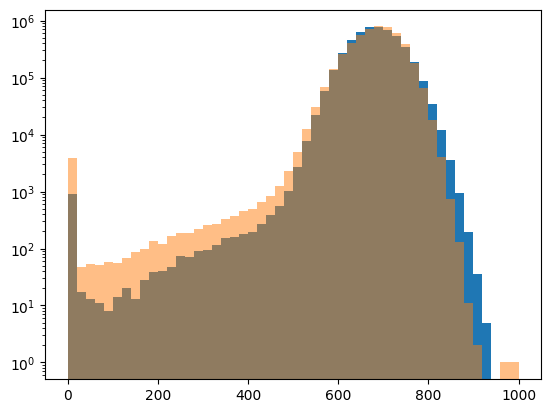

In [499]:
pred_counts, pred_bins = np.histogram(pred_plus_mc, bins=50, range=(0,1000))
obs_counts, obs_bins = np.histogram(obs, bins=50, range=(0,1000))
#obs_counts_fast, obs_bins_fast = np.histogram(y_fast_sel, bins=100, range=(0,1000))
#plt.hist(obs_bins_fast[:-1], obs_bins_fast, weights=obs_counts_fast, alpha=1)
#plt.hist(obs_bins[:-1], obs_bins, weights=obs_counts, alpha=0.5)
#plt.yscale('log')
#plt.show()
plt.hist(pred_bins[:-1], pred_bins, weights=pred_counts, alpha=1)
plt.hist(obs_bins[:-1], obs_bins, weights=obs_counts, alpha=0.5)
plt.yscale('log')
plt.show()

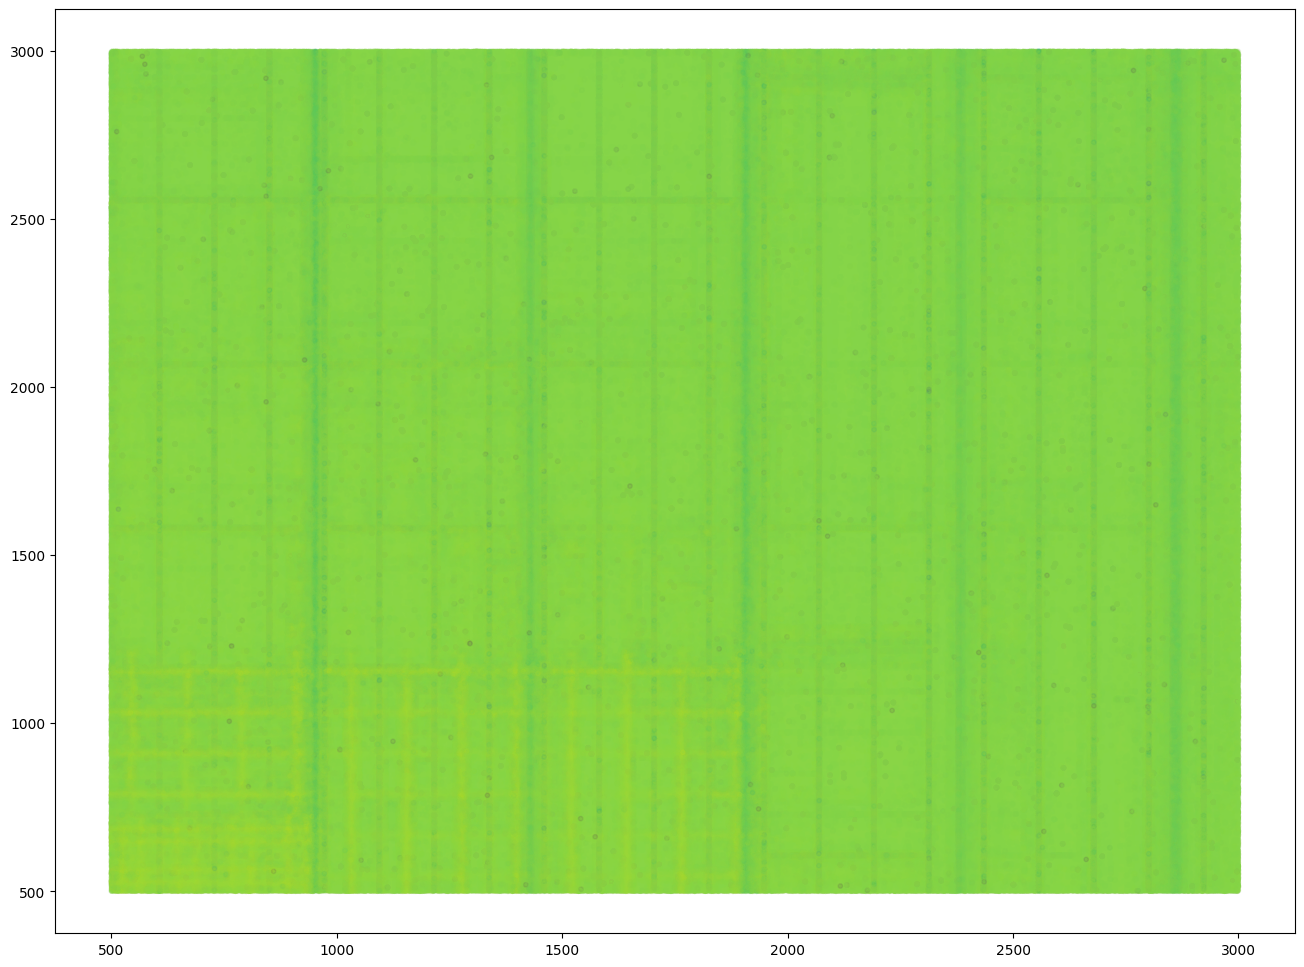

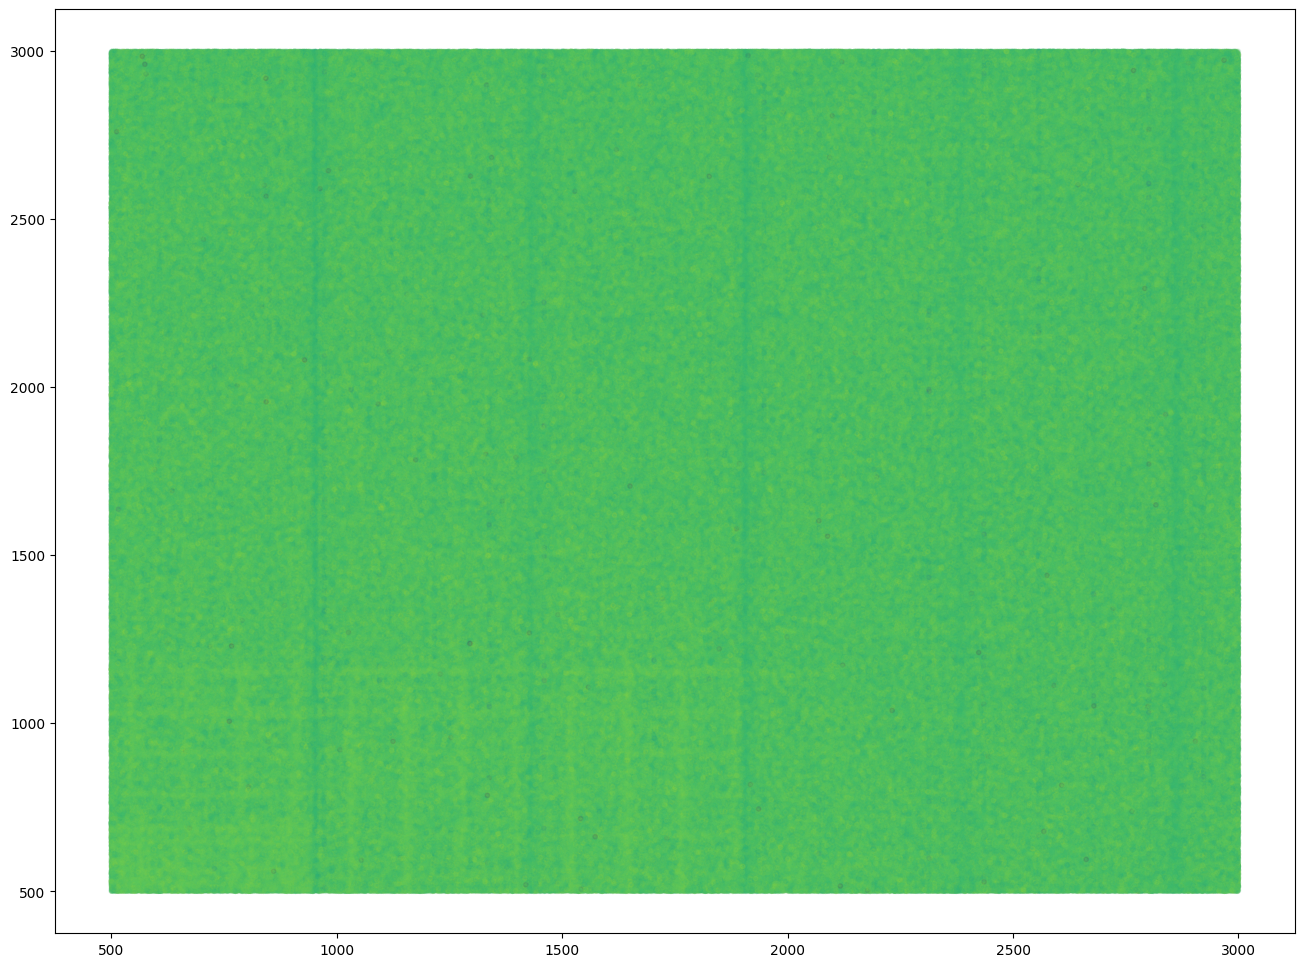

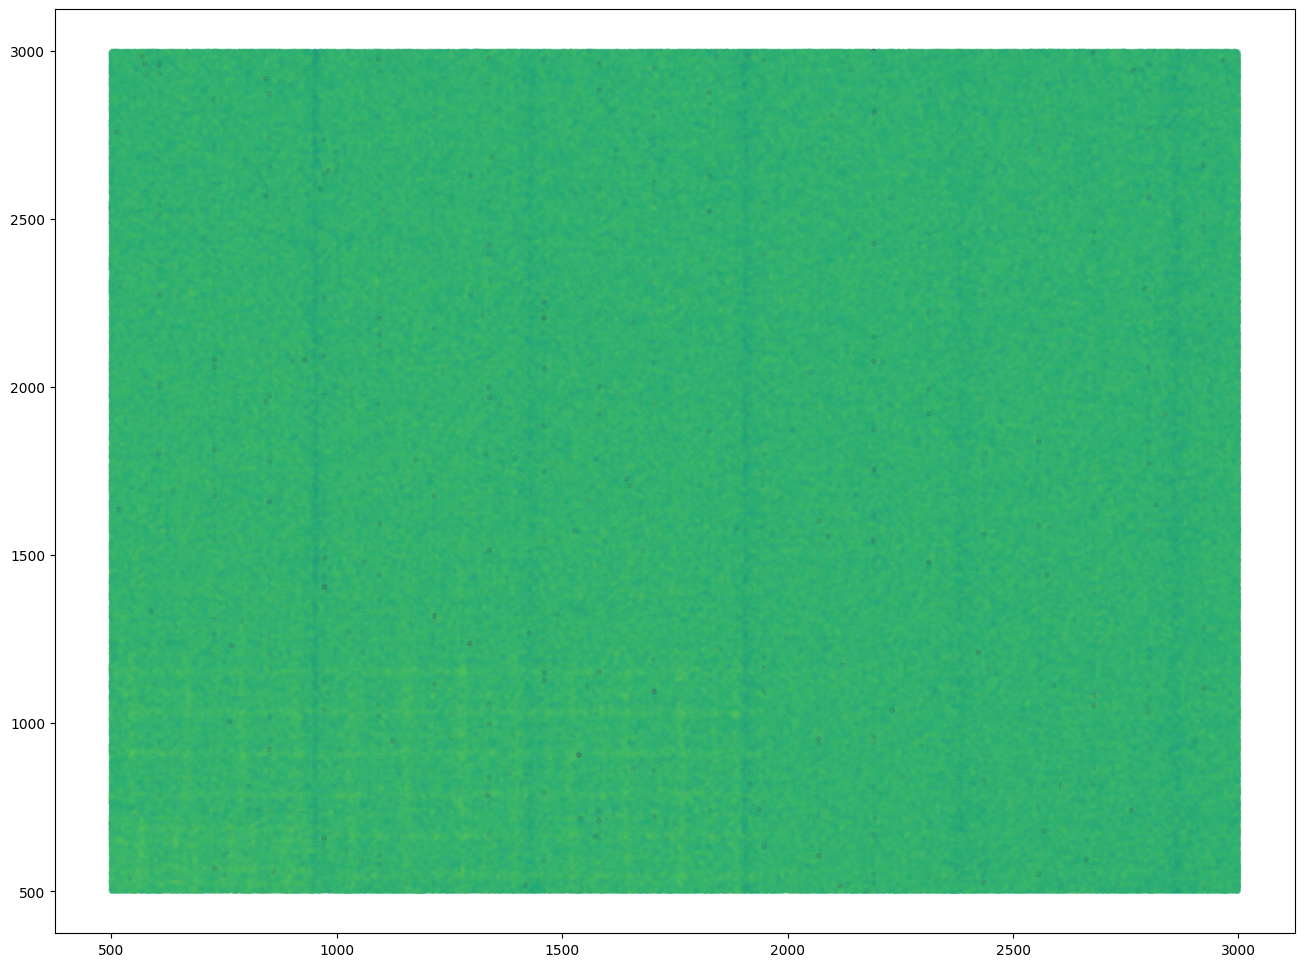

In [500]:
plt.figure(figsize=(16,12))
plt.scatter(np.transpose(X_sel)[1], np.transpose(X_sel)[2], c=pred, s=10, alpha=0.1)
plt.show()
plt.figure(figsize=(16,12))
plt.scatter(np.transpose(X_sel)[1], np.transpose(X_sel)[2], c=pred_plus_mc, s=10, alpha=0.1)
plt.show()
plt.figure(figsize=(16,12))
plt.scatter(np.transpose(X_sel)[1], np.transpose(X_sel)[2], c=obs, s=10, alpha=0.1)
plt.show()

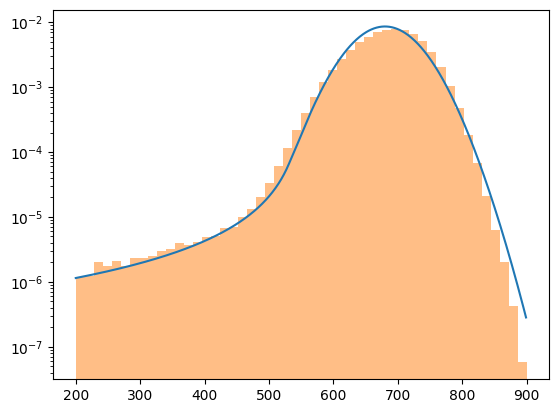

In [471]:
obs_counts, obs_bins = np.histogram(obs, bins=50, range=(200,900), density=True)
plt.plot(range(200,900), (crystalball.pdf(range(200,900), 3, 1.9, loc=680, scale=50)+crystalball.pdf(range(200,900), 3, 1.5, loc=680, scale=43))/2)
plt.hist(obs_bins[:-1], obs_bins, weights=obs_counts, alpha=0.5)
plt.yscale('log')
plt.show()

In [453]:
def double_cball(x, beta_1, m_1, loc_1, scale_1, beta_2, m_2, loc_2, scale_2):
    return (crystalball.pdf(x, beta_1, m_1, loc=loc_1, scale=scale_1)+crystalball.pdf(x, beta_2, m_2, loc=loc_2, scale=scale_2))/2

In [457]:
expected = [3,1.9,680,50,3,1.5,700,43]
obs_bins=(obs_bins[1:]+obs_bins[:-1])/2

In [458]:
params,cov=curve_fit(double_cball,obs_bins,obs_counts,expected)

/var/folders/w4/r1995s014fv25t05nkdm04g00000gn/T/ipykernel_81600/1793584540.py:1: OptimizeWarning: Covariance of the parameters could not be estimated
  params,cov=curve_fit(double_cball,obs_bins,obs_counts,expected)


In [479]:
params

(3, 1.9, 680, 50, 3, 1.5, 700, 43)

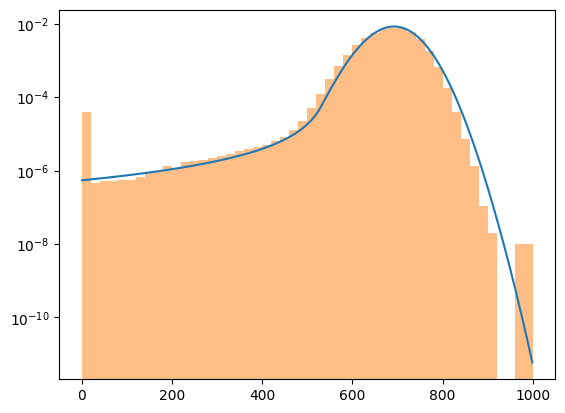

In [480]:
obs_counts, obs_bins = np.histogram(obs, bins=50, range=(0,1000), density=True)
plt.plot(range(0,1000), double_cball(range(0,1000), *params))
plt.hist(obs_bins[:-1], obs_bins, weights=obs_counts, alpha=0.5)
plt.yscale('log')
plt.show()

In [422]:
def bump_function(x, a, b, c, d, rho=1):
    if x > a and x< b:
        return np.exp(-rho * (abs(x-b)**2)/(abs(x-a)**2))
    elif x > c and x < d:
        return np.exp(-rho * (abs(x-c)**2)/(abs(x-d)**2))
    elif x <= a:
        return 0
    elif x >= d:
        return 0
    else:
        return 1

def gamma_bump(x, gamma=0.00075, loc=680):
    return 1/(gamma*(loc-x)**2+1)

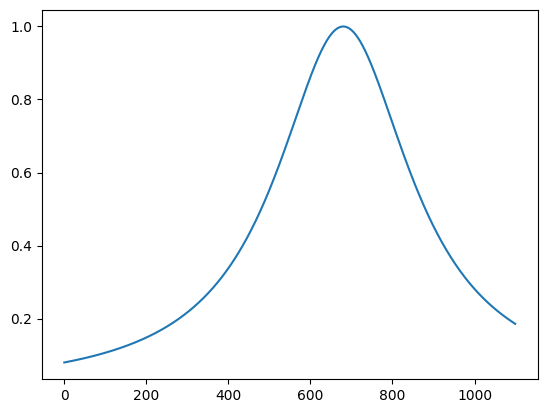

In [483]:
plt.plot(range(0,1100), [gamma_bump(x, gamma = 0.000025) for x in range(0,1100)])

In [ ]:
x = np.linspace(0, 1000, 5000000)

In [501]:
a,b,c,d = 500,700,700,800
pred_plus_mc = [samples[i]*gamma_bump(pred[i],  gamma = 0.00075) + (1-gamma_bump(pred[i], gamma = 0.00075))*pred[i] for i in range(5000000)]

In [473]:
params = expected

In [488]:
samples = [
    (crystalball.rvs(beta = params[0], m = params[1], loc = p, scale = 55)
    +crystalball.rvs(beta = params[4], m = params[5], loc = p, scale = 55))/2
    for p in pred
]

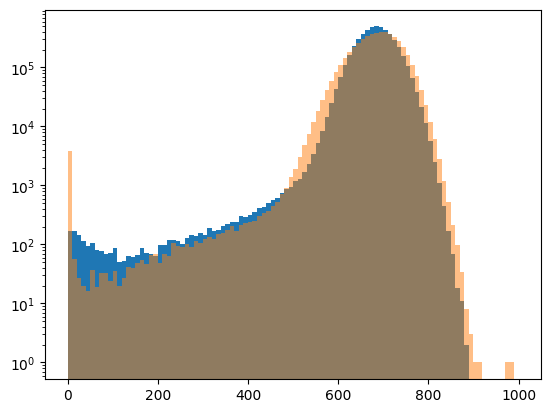

In [502]:
sample_counts, sample_bins = np.histogram(samples, bins=100, range=(0,1000))
obs_counts, obs_bins = np.histogram(obs, bins=100, range=(0,1000))
plt.hist(sample_bins[:-1], sample_bins, weights=sample_counts, alpha=1)
plt.hist(obs_bins[:-1], obs_bins, weights=obs_counts, alpha=0.5)
plt.yscale("log")
plt.show()

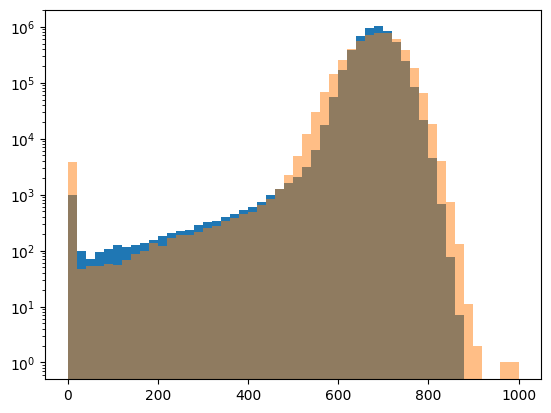

In [503]:
pred_counts, pred_bins = np.histogram(pred_plus_mc, bins=50, range=(0,1000))
obs_counts, obs_bins = np.histogram(obs, bins=50, range=(0,1000))
#obs_counts_fast, obs_bins_fast = np.histogram(y_fast_sel, bins=100, range=(0,1000))
#plt.hist(obs_bins_fast[:-1], obs_bins_fast, weights=obs_counts_fast, alpha=1)
#plt.hist(obs_bins[:-1], obs_bins, weights=obs_counts, alpha=0.5)
#plt.yscale('log')
#plt.show()
plt.hist(pred_bins[:-1], pred_bins, weights=pred_counts, alpha=1)
plt.hist(obs_bins[:-1], obs_bins, weights=obs_counts, alpha=0.5)
plt.yscale('log')
plt.show()

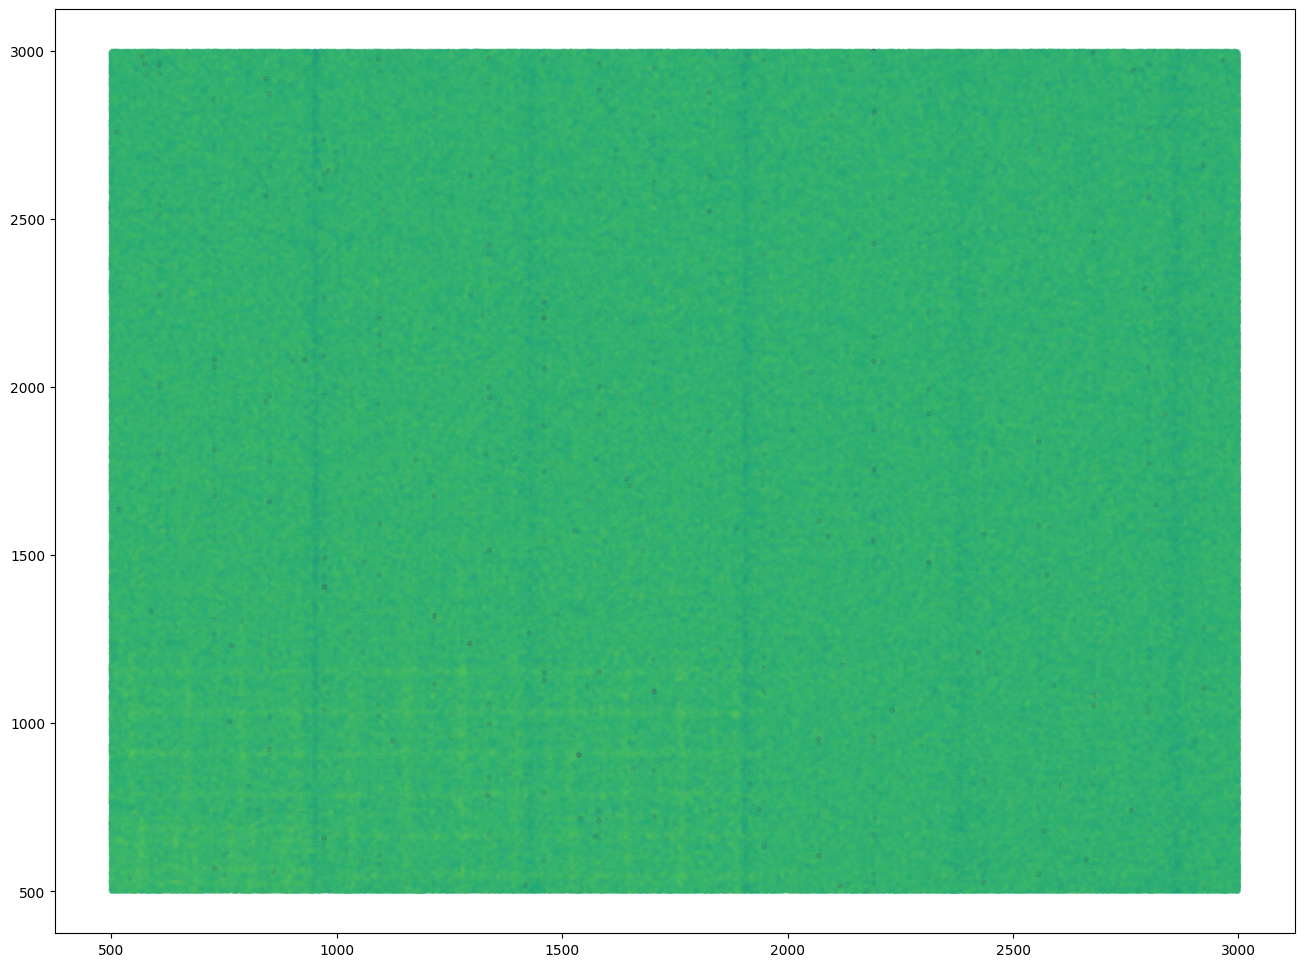

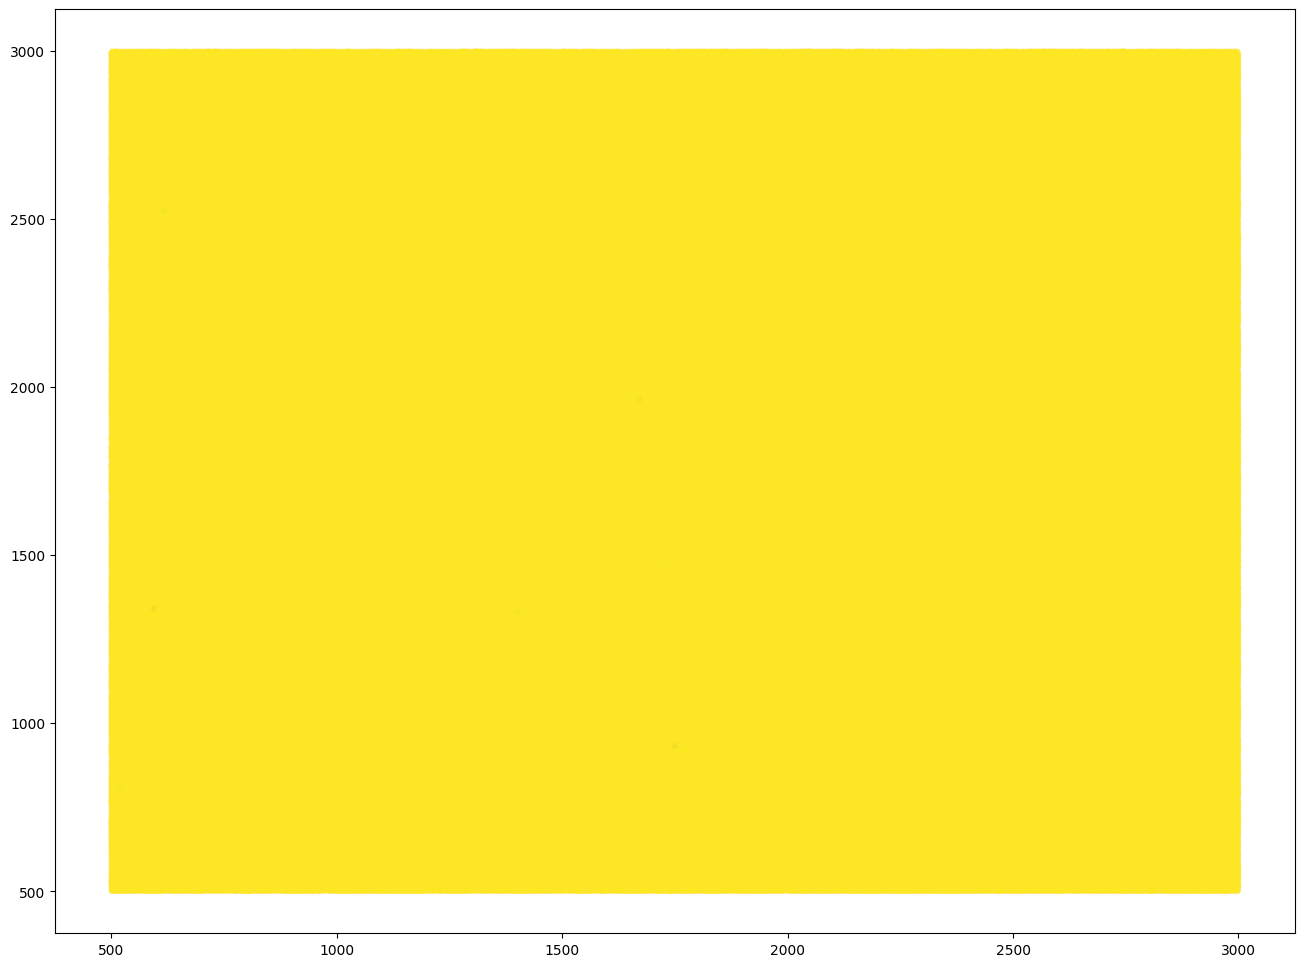

In [504]:
plt.figure(figsize=(16,12))
plt.scatter(np.transpose(X_sel)[1], np.transpose(X_sel)[2], c=obs, s=10, alpha=0.1)
plt.show()
plt.figure(figsize=(16,12))
plt.scatter(np.transpose(X_sel)[1], np.transpose(X_sel)[2], c=pred_plus_mc, s=10, alpha=0.1)
plt.show()